### By Raghuram Palaniappan

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
images = np.load('images.npy')
labels = pd.read_csv('Labels.csv')  

## Data Overview

### Understand the shape of the dataset

In [3]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


#### Observations: The data set has 4750 observations.

## Exploratory Data Analysis

### Plotting random images from each of the class

In [4]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

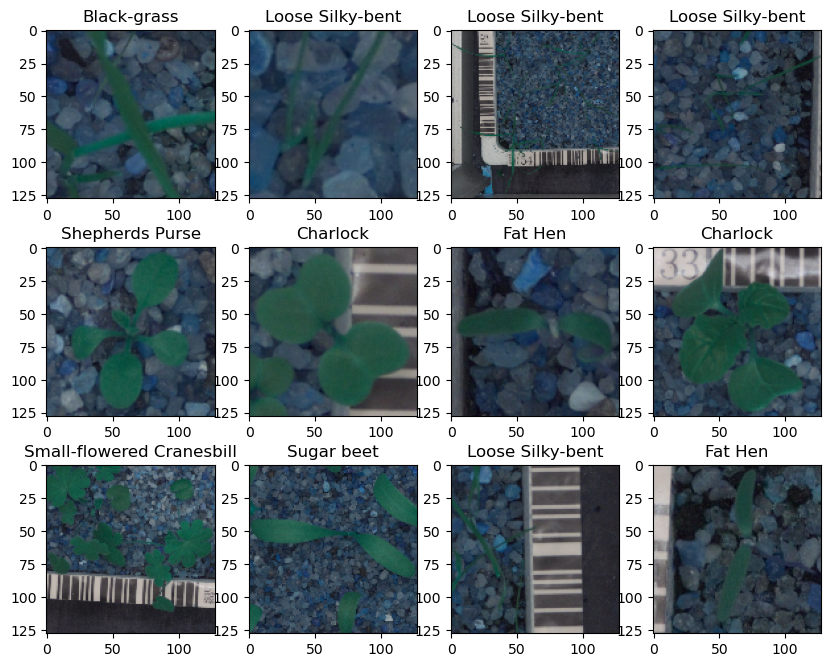

In [5]:
plot_images(images,labels) 

### Checking the distribution of the target variable

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

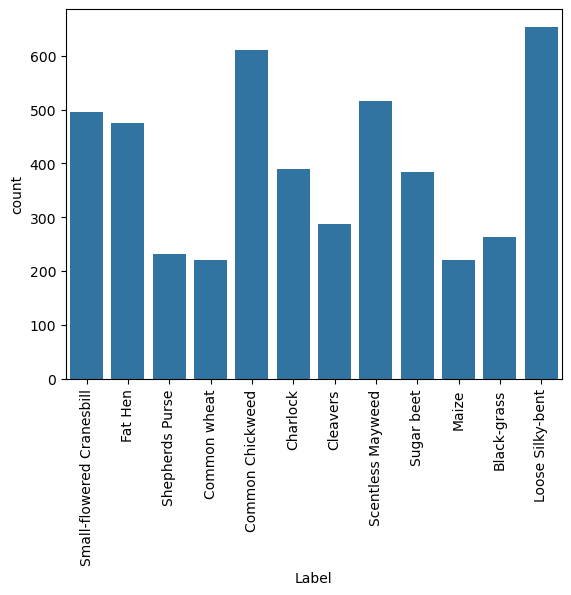

In [6]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

#### Observations: The different target categories are not uniformly distributed. This means there may be some bias in the models and the models might be better at predicting categories that have more counts.

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [7]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)   

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [8]:
images_decreased=[]
height = 64           
width =  64           
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

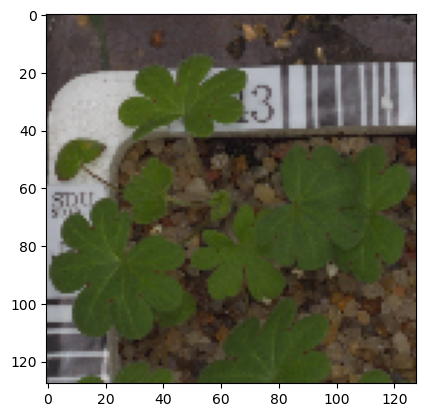

In [9]:
plt.imshow(images[3])

**Image after resizing**

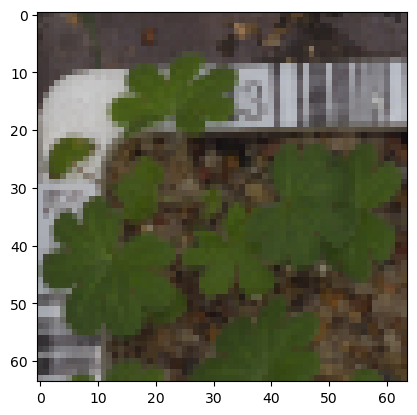

In [10]:
plt.imshow(images_decreased[3])

#### Observations: Due to the image de-sizing, the images are now less clear. However, this is necessary to reduce computational power. The laptop I am in possession of cannot compute too much.

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)  
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       

In [12]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


#### Observations: Splitting the data set into train, validation, and test sets allow us to check our trained models on validation sets before testing finally on the test set.

### Encoding the target labels

In [13]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                                
y_train_encoded = enc.fit_transform(y_train)        
y_val_encoded=enc.transform(y_val)                  
y_test_encoded=enc.transform(y_test)                

In [14]:
y_train_encoded.shape,y_val.shape,y_test.shape 

((3847, 12), (428, 1), (475, 1))

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [15]:
# Complete the code to normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

#### Observations: We are preprocessing the data by normalizing the predictive data set and encoding the categories in the target variable.

## Model Building

### Building a CNN Model

1. Clear the previous model's history from the session even if a single model can run multiple times on the same data.
2. Set a seed to reproduce results if necessary.
3. Build sequential model with necessary layers
4. Fit model with 30 epochs
5. View metrics of model

In [16]:
# Clearing backend
backend.clear_session()

In [17]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Model 1

In [18]:
# Intializing a sequential model
model1 = Sequential()

# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Add a fully connected dense layer with 16 neurons
model1.add(Dense(units=16, activation='relu'))
model1.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(units=12, activation='softmax'))

# Adam Optimizer
opt=Adam()
# Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

<b> Fitting the model on the train data

In [19]:
# Fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2   
)

Epoch 1/30
121/121 - 21s - 176ms/step - accuracy: 0.1284 - loss: 2.4440 - val_accuracy: 0.2547 - val_loss: 2.3155
Epoch 2/30
121/121 - 19s - 154ms/step - accuracy: 0.2420 - loss: 2.1853 - val_accuracy: 0.3364 - val_loss: 2.0053
Epoch 3/30
121/121 - 22s - 183ms/step - accuracy: 0.3210 - loss: 1.9336 - val_accuracy: 0.3621 - val_loss: 1.7750
Epoch 4/30
121/121 - 23s - 188ms/step - accuracy: 0.3416 - loss: 1.8357 - val_accuracy: 0.4299 - val_loss: 1.5922
Epoch 5/30
121/121 - 20s - 164ms/step - accuracy: 0.3951 - loss: 1.6868 - val_accuracy: 0.4299 - val_loss: 1.6579
Epoch 6/30
121/121 - 20s - 163ms/step - accuracy: 0.4221 - loss: 1.5858 - val_accuracy: 0.5093 - val_loss: 1.4136
Epoch 7/30
121/121 - 32s - 262ms/step - accuracy: 0.4583 - loss: 1.4806 - val_accuracy: 0.5678 - val_loss: 1.2158
Epoch 8/30
121/121 - 24s - 196ms/step - accuracy: 0.4773 - loss: 1.4316 - val_accuracy: 0.5771 - val_loss: 1.2399
Epoch 9/30
121/121 - 22s - 183ms/step - accuracy: 0.4882 - loss: 1.3791 - val_accuracy: 

#### Observations: This is a very computationally instensive model since it took almost 10 minutes to train on the laptop. The final accuracy provided at the 30th epoch is 62.39%. The loss consistently decreased from epoch to epoch.

**Model Evaluation**

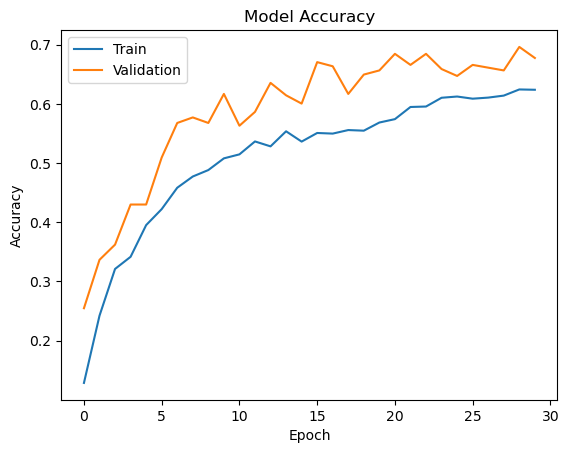

In [21]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [22]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 58ms/step - accuracy: 0.6779 - loss: 1.0593


#### Observations: The 1st model on the validation and test data got higher accuracy metrics than the training data. This may be a result of the target variable having a lot of counts in certain categories. The val and test dataset could have had more of those types of categories. This could result in this increase in score. The train model was definitely not overfit.

**Plotting the Confusion Matrix**

In [23]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                       

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


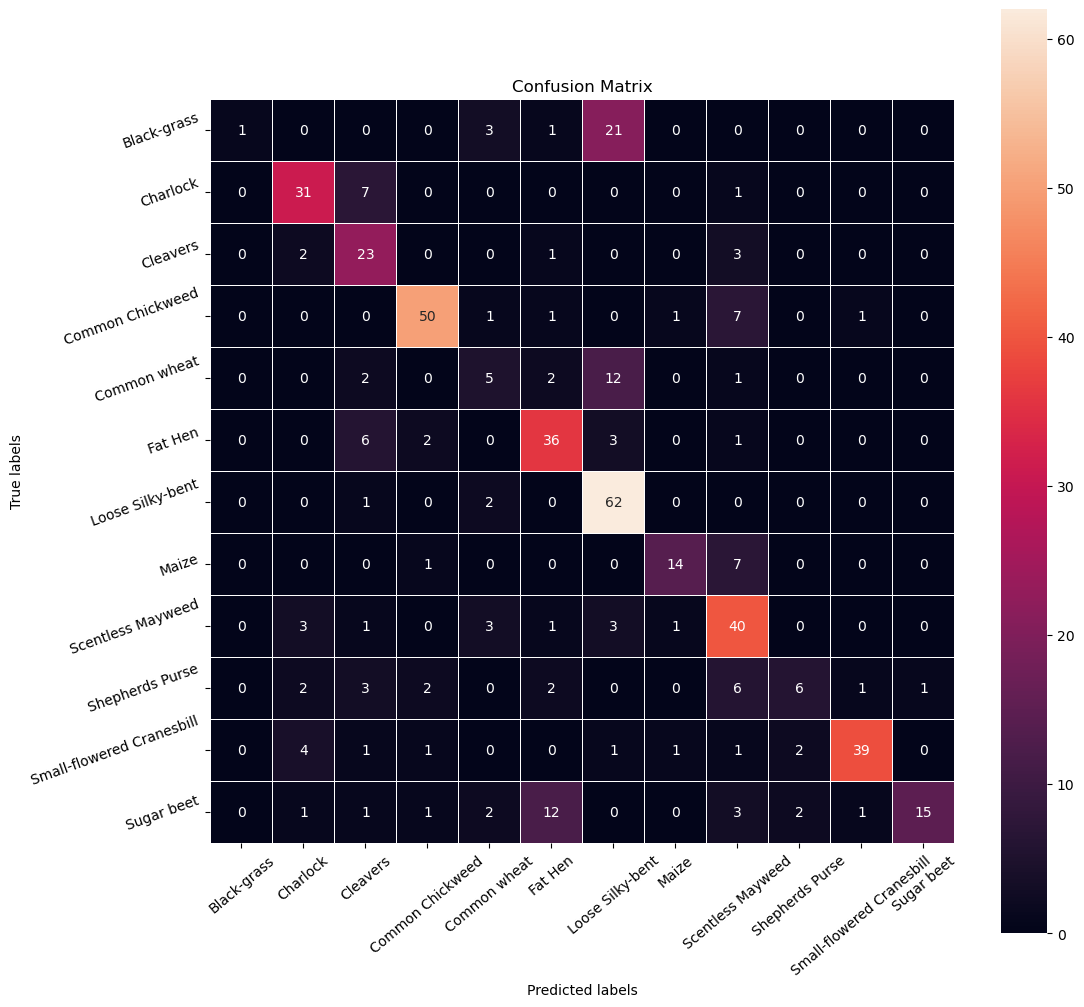

<Figure size 500x500 with 0 Axes>

In [27]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)            
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.figure(figsize=(5,5))
plt.show()

**Plotting Classification Report**

In [30]:
# Plotting the classification report
from sklearn.metrics import classification_report

cr=classification_report(y_test_arg,y_pred_arg)   
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        26
           1       0.72      0.79      0.76        39
           2       0.51      0.79      0.62        29
           3       0.88      0.82      0.85        61
           4       0.31      0.23      0.26        22
           5       0.64      0.75      0.69        48
           6       0.61      0.95      0.74        65
           7       0.82      0.64      0.72        22
           8       0.57      0.77      0.66        52
           9       0.60      0.26      0.36        23
          10       0.93      0.78      0.85        50
          11       0.94      0.39      0.56        38

    accuracy                           0.68       475
   macro avg       0.71      0.60      0.59       475
weighted avg       0.72      0.68      0.65       475



#### Observations: The test data has strong precision values. This is a strong metric to be strong in since high precision means low false positives.

## Model 2

## Model 2 Steps

1. Clear the previous model's history from the session.
2. Set a seed to reproduce results if necessary.
3. Reduce learning rate and set Rotation Range to 20
4. Build sequential model with necessary layers
5. Fit model with 30 epochs
6. View metrics of model

## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [31]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [33]:
# Code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [32]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
# Intializing a sequential model
model2 = Sequential()

# Add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Initialize Adam Optimimzer
opt =Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       131,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,676 (592.48 KB)

 Trainable params: 151,612 (592.23 KB)

 Non-trainable params: 64 (256.00 B)

<b> Fitting the model on the train data

In [35]:
# Fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.1816 - loss: 2.3586 - val_accuracy: 0.2523 - val_loss: 2.3881 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4219 - loss: 1.5636 - val_accuracy: 0.3084 - val_loss: 2.3854 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.3954 - loss: 1.8298 - val_accuracy: 0.2266 - val_loss: 2.3624 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 1.6616 - val_accuracy: 0.2407 - val_loss: 2.3657 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.4727 - loss: 1.6276 - val_accuracy: 0.3131 - val_loss: 2.2708 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 1.6408 - val_accuracy: 0.3762 - val_loss: 2.2475 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.5118 - loss: 1.4772 - va

**Model Evaluation**

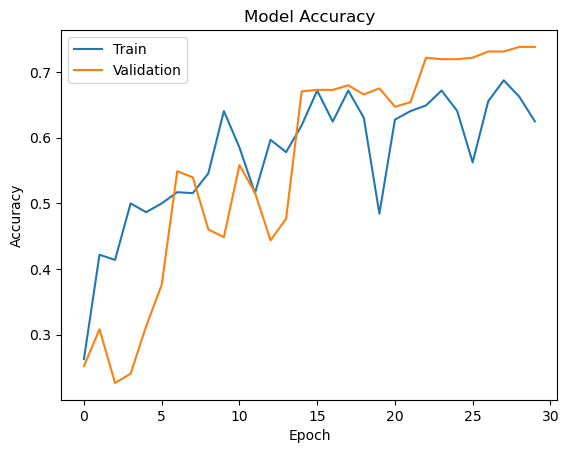

<Figure size 500x500 with 0 Axes>

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.figure(figsize=(5,5))
plt.show()

**Evaluate the model on test data**

In [37]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2) 

15/15 - 0s - 21ms/step - accuracy: 0.7453 - loss: 0.8478


#### Observations: The 2nd model on the validation and test data got higher accuracy metrics than the training data. This once again may be a result of the target variable having a lot of counts in certain categories. The val and test dataset could have had more of those types of categories. This time of accuracy on the train model is higher at around .73.

**Plotting the Confusion Matrix**

In [38]:
# Complete the code to obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


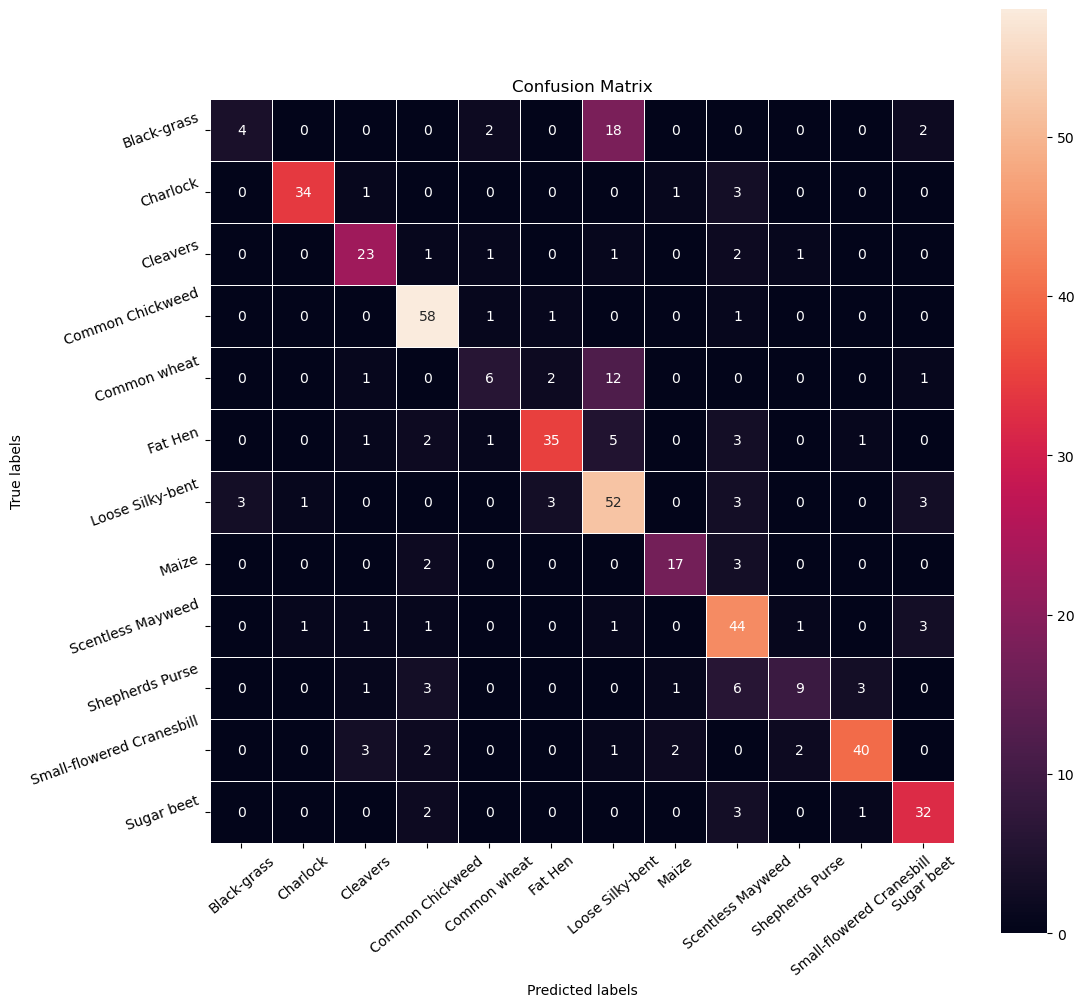

<Figure size 500x500 with 0 Axes>

In [40]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.figure(figsize=(5,5))
plt.show()

**Plotting Classification Report**

In [41]:
# Plotting the classification report
cr = classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.57      0.15      0.24        26
           1       0.94      0.87      0.91        39
           2       0.74      0.79      0.77        29
           3       0.82      0.95      0.88        61
           4       0.55      0.27      0.36        22
           5       0.85      0.73      0.79        48
           6       0.58      0.80      0.67        65
           7       0.81      0.77      0.79        22
           8       0.65      0.85      0.73        52
           9       0.69      0.39      0.50        23
          10       0.89      0.80      0.84        50
          11       0.78      0.84      0.81        38

    accuracy                           0.75       475
   macro avg       0.74      0.69      0.69       475
weighted avg       0.75      0.75      0.73       475



#### Observations: This model has weaker precision but produced higher accuracy. The accuracy produced on the test model is 0.75.

## Final Model

#### The final model that is used is Model 2. Even though Model 1 had a stronger precision, Model 2 has the highest accuracy. In our use case, our goal is to accurately predict what the plant category is. This means that accuracy is the most important metric in our model. 

### Visualizing the prediction

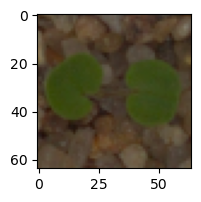

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


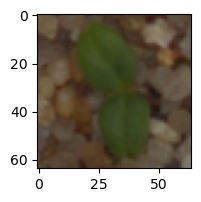

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label ['Cleavers']
True Label Cleavers


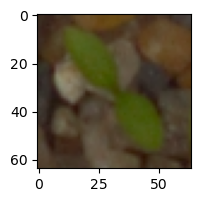

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


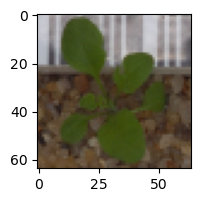

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [42]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

#### Observation: Our model correctly predicted all 4 above images.

## Actionable Insights and Business Recommendations

## Conclusion
- We can observe from the confusion matrix of all the models that our Data Augmentation model (Model2) was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the Final Model is around 75%.
- Model 1 produced stronger precision scores, however that did not fit out use case of the models.

## Areas of Improvement
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64. This would require greater computation resources.
- Data Augmentation could be utilized more to improve the model performance.
- The data set could have been set up to have an equal amount of observations for every category. This way the model will not be biased to predicting certain categories at a stronger rate.

### By Raghuram Palaniappan

_____